In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('datasets/water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Analysis
 - First we must check which columns have NaN values

In [3]:
scatter_columns = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
has_nan = {}
for column in scatter_columns:
    if df[column].isnull().values.any():
        has_nan[column] = True

print(has_nan)

{'ph': True, 'Sulfate': True, 'Trihalomethanes': True}


In [4]:
for column in has_nan:
    print(f'"{column}" has {len(df[column].isnull().values)} NaN values')

"ph" has 3276 NaN values
"Sulfate" has 3276 NaN values
"Trihalomethanes" has 3276 NaN values


## Analysis
- We will train predictors to replace the values that we are missing

In [5]:
predictor_cols = [col for col in scatter_columns if col not in has_nan]
print(predictor_cols)

['Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']


In [6]:
from sklearn.linear_model import LinearRegression

df_filled = df.copy()
for col in has_nan:
    model = LinearRegression()
    # extract all columns that have full data plus the column we need to impute
    data_with_null = df_filled[predictor_cols + [col]]
    data_without_null = data_with_null.dropna()
    
    train_data_x = data_without_null[predictor_cols]
    train_data_y = data_without_null[col]
    
    model.fit(train_data_x, train_data_y)
    test_data = data_with_null[predictor_cols]
    predicted = pd.DataFrame(model.predict(test_data), columns=[col])
    df_filled[col].fillna(predicted[col], inplace=True)


In [7]:
df_dropped = df.dropna()
df_filled.isnull().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
Potability         False
dtype: bool

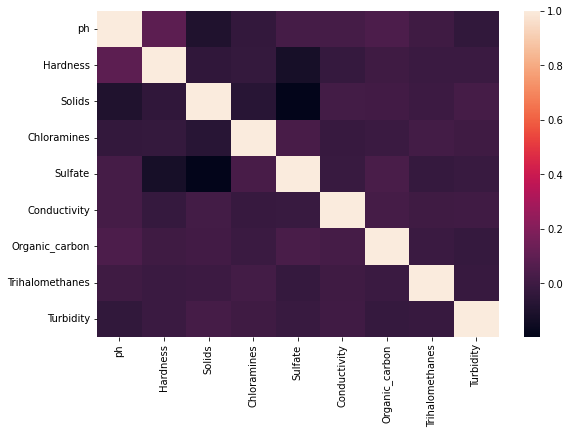

In [8]:
import seaborn as sn
# reparse the numpy matrix to df

correlation = df_filled[df_filled.columns.drop('Potability')].corr()
_, _ = plt.subplots(figsize=(9, 6))
sn.heatmap(correlation, annot=False)
plt.show()

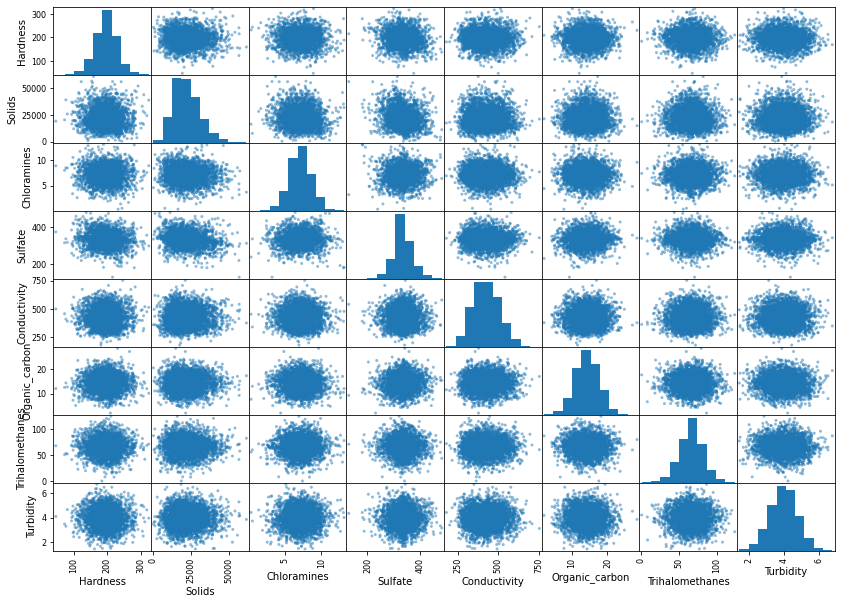

In [9]:
from pandas.plotting import scatter_matrix

# headers = list(df.columns.values)
# df_headers = pd.DataFrame(X_clean, columns=headers)
scatter_columns = ['Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
axs = scatter_matrix(df_filled[scatter_columns], figsize=(14, 10))

## Analysis
- Above, we can see that there doesn't *seem* to be any correlation among attributes, however the feature scales are very very different
- we can apply normalization techniques in order to put them on a similar scale

In [19]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

df_non_normalized = df_filled
df_normalized_z_score = z_score(df_filled[df_filled.columns.drop('Potability')])
df_dropped_normalized = z_score(df_dropped[df_dropped.columns.drop('Potability')])


df_normalized_z_score.describe()


# scatter_columns = ['Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
# axs = scatter_matrix(df_normalized_z_score[scatter_columns], figsize=(14, 10))

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,3.276000e+03,3276.000000,3.276000e+03,3.276000e+03,3276.000000,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03
mean,-1.626700e-18,0.000000,-2.060487e-17,1.735147e-17,0.000000,-1.355584e-17,1.301360e-17,-2.819614e-17,-3.253401e-17
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.809074e+00,-4.529762,-2.473966e+00,-4.276635e+00,-5.624879,-3.027828e+00,-3.653077e+00,-4.163292e+00,-3.225068e+00
25%,-5.450075e-01,-0.593647,-7.238810e-01,-6.284287e-01,-0.487745,-7.481769e-01,-6.708163e-01,-6.180632e-01,-6.754064e-01
50%,-1.253952e-02,0.018191,-1.238810e-01,5.067435e-03,0.001194,-5.345119e-02,-2.014179e-02,5.423242e-03,-1.506775e-02
75%,5.366038e-01,0.617339,6.065606e-01,6.270101e-01,0.464439,6.877555e-01,6.869921e-01,6.513379e-01,6.836823e-01
max,4.700331e+00,3.855092,4.472006e+00,3.793052e+00,4.044914,4.047526e+00,4.236500e+00,3.652746e+00,3.552379e+00


## Analysis
 - We still see very little correlation between different features. This means we can most likely keep all the features in the dataset as they bring unique information to the model.
 - Next we will prepare the train, test, and validation sets

In [20]:
df_filled = df_normalized_z_score.assign(Potability=df_filled['Potability'])
df_dropped_normalized = df_dropped_normalized.assign(Potability=df_dropped['Potability'])
print(df_filled.shape)

(3276, 10)


In [21]:
df_filled.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3.276000e+03,3276.000000,3.276000e+03,3.276000e+03,3276.000000,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3276.000000
mean,-1.626700e-18,0.000000,-2.060487e-17,1.735147e-17,0.000000,-1.355584e-17,1.301360e-17,-2.819614e-17,-3.253401e-17,0.390110
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.487849
min,-4.809074e+00,-4.529762,-2.473966e+00,-4.276635e+00,-5.624879,-3.027828e+00,-3.653077e+00,-4.163292e+00,-3.225068e+00,0.000000
25%,-5.450075e-01,-0.593647,-7.238810e-01,-6.284287e-01,-0.487745,-7.481769e-01,-6.708163e-01,-6.180632e-01,-6.754064e-01,0.000000
50%,-1.253952e-02,0.018191,-1.238810e-01,5.067435e-03,0.001194,-5.345119e-02,-2.014179e-02,5.423242e-03,-1.506775e-02,0.000000
75%,5.366038e-01,0.617339,6.065606e-01,6.270101e-01,0.464439,6.877555e-01,6.869921e-01,6.513379e-01,6.836823e-01,1.000000
max,4.700331e+00,3.855092,4.472006e+00,3.793052e+00,4.044914,4.047526e+00,4.236500e+00,3.652746e+00,3.552379e+00,1.000000


In [22]:
from sklearn.model_selection import train_test_split
import time

def clean_and_arrange(df_in):
    as_matrix = df_in.to_numpy()
    num_samples, feature_length = np.size(as_matrix, 0), np.size(as_matrix, 1)
    X = as_matrix[:,0:feature_length-1]
    print(f'X shape: {X.shape}')
    y = as_matrix[:,feature_length-1:feature_length]
    print(f'y shape: {y.shape}')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=int(time.time()))

    # give y_train the same shape so it can be concatenated
    y_train = np.resize(y_train, (len(y_train),1))
    # add it back to X_train as the lables
    X_train_full = np.concatenate((X_train, y_train), 1)

    
    # VALIDATION SET
    # X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.50, random_state=int(time.time()))
    
    # give y_test the same shape so it can be concatenated
    # y_val = np.resize(y_val, (len(y_val),1))
    # add it back to X_test as the lables
    # X_val_full = np.concatenate((X_val, y_val), 1)
    
    # give y_test the same shape so it can be concatenated
    y_test = np.resize(y_test, (len(y_test),1))
    # add it back to X_test as the lables
    X_test_full = np.concatenate((X_test, y_test), 1)   

    # recombine X, now data is organized - training data precedes the test data
    X_clean = np.concatenate((X_train_full, X_test_full), 0)
    
    # UNCOMMENT IF VALIDATION IS USED
    #X_clean = np.concatenate((X_clean, X_val_full), 0)
    
    num_train = np.size(X_train, 0)
    num_test = np.size(X_test, 0)
    
    # UNCOMMENT IF VALIDATION IS USED
    # num_val = np.size(X_val, 0)

    # ensure our output has the same shape as the input
    print(f'X_clean shape: {X_clean.shape}')
    
    return pd.DataFrame(X_clean), (num_train, num_test) #, num_val)

In [23]:
# reform the dataframe
def clean_and_write_df(df, name):
    df_clean, (num_train, num_test) = clean_and_arrange(df)

    print(f'Train size: {num_train}')
    print(f'Test size: {num_test}')
    
    with open(f'datasets/{name}_sizes.csv', 'w') as sample_size_file:
        sample_size_file.writelines(f'{num_train}, {num_test}')
        
    # transpose the matrix so sample is a column
    df_clean.T.to_csv(f'datasets/{name}_cleaned.csv', index = False, index_label = False, header=False)

In [24]:
clean_and_write_df(df_non_normalized, 'water')
clean_and_write_df(df_filled, 'water_normalized')
clean_and_write_df(df_dropped, 'water_dropped')
clean_and_write_df(df_dropped_normalized, 'water_dropped_normalized')

X shape: (3276, 9)
y shape: (3276, 1)
X_clean shape: (3276, 10)
Train size: 2620
Test size: 656
X shape: (3276, 9)
y shape: (3276, 1)
X_clean shape: (3276, 10)
Train size: 2620
Test size: 656
X shape: (2011, 9)
y shape: (2011, 1)
X_clean shape: (2011, 10)
Train size: 1608
Test size: 403
X shape: (2011, 9)
y shape: (2011, 1)
X_clean shape: (2011, 10)
Train size: 1608
Test size: 403


## Export 
- Transpose the data so each column is a sample instead of row
- Export to Csv